## Gaussian Mixture Models for TIMIT

+ ###### Authors: Dirk Van Compernolle
+ ###### History:  04/2022, 17/03/2023
+ ###### Requires: pyspch v0.7   

Content:
- Training of GMMs for all phonemes
- Frame CLassification
- Applying the models for utterance analysis


In [1]:
#!pip install git+https://github.com/compi1234/pyspch.git
try:
    import pyspch
except ModuleNotFoundError:
    try:
        print(
        """
        To enable this notebook on platforms as Google Colab, 
        install the pyspch package and dependencies by running following code:

        !pip install git+https://github.com/compi1234/pyspch.git
        """
        )
    except ModuleNotFoundError:
        raise

In [2]:
%matplotlib inline
import io, os, sys
import logging

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
import requests
import importlib
import urllib.request
import pickle
import gzip
from pyspch.stats import GMM
from sklearn import metrics as skmetrics 
from IPython.display import display, HTML, Audio

# reproducibility 
torch.manual_seed(0) 
np.random.seed(0)
logging.basicConfig(level=logging.INFO)

# print and plot
np.set_printoptions(precision=3)
cmap_jet2 = sns.mpl_palette("jet",60)[5:55]

# pyspch
import pyspch
import pyspch.nn
from pyspch.stats import GMM
import pyspch.core as Spch

# device
use_cuda_if_available = True
if use_cuda_if_available:
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 
else:
    device = "cpu"

In [3]:
#@title Auxiliary functions 

# download from url and write to file
def write_from_url(url, filename):
    r = requests.get(url)
    with open(filename, 'wb') as f:
        f.write(r.content)

# dictionairy
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
def dict_from_module(module):
    context = {}
    for setting in dir(module):
        # you can write your filter here
        if not setting.startswith('_'):
            context[setting] = getattr(module, setting)

    return context

# import setup file (.py) as module (dotdict)
def read_setup(filename, new_read_path=None, old_read_path='/users/spraak/spchlab/public_html/data/timit/'):
    
    # load module
    spec = importlib.util.spec_from_file_location(os.path.basename(filename), filename)
    setup = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(setup)
    
    # convert to dict 
    setup = dict_from_module(setup)
    setup = dotdict(setup)

    # replace esat_path with root_url
    if new_read_path is not None:
        for k, v in setup.items():
            if type(v) == str:
                setup[k] = v.replace(old_read_path, new_read_path)
            
    return setup

In [4]:
# Utility for importing TIMIT data
timit_root = 'https://homes.esat.kuleuven.be/~spchlab/data/timit/'
def get_timit_data(subcorpus="",ftrs_in="mfcc13",alphabet='timit41',feature_args={}):
    '''
    get (part of) TIMIT corpus from disk
    and process all features for the defined feature extraction
    
    subcorpus:     "", "_mini", "_dr1"   for full, mini(10%), single subdirectory dr1
    ftrs_in:       type of preprocessed features to start from
    alphabet:      choice of alphabet to use  (TIMIT61 should be convertable to it)
    feature_args:  definition of desired feature extraction, should be compatible with  ftrs_in
    '''
    #

    corpus_path = timit_root + 'conf/'
    train_corpus_file = corpus_path + 'timit_train'+subcorpus+'.corpus'
    test_corpus_file = corpus_path + 'timit_test'+subcorpus+'.corpus'
    feature_path = timit_root + 'features/'+ ftrs_in + '/'
    train_pickle_file = feature_path + 'train.pkl'
    test_pickle_file = feature_path + 'test.pkl'
    # read train corpus and features
    train_corpus = pyspch.read_txt(train_corpus_file)
    train_df = pd.read_pickle(train_pickle_file)
    train_data = pyspch.core.DataFrame_to_SpchData(train_df, delete_df=True) 
    train_data = train_data.subset(train_corpus) 
    # read test corpus and features 
    test_corpus = pyspch.read_txt(test_corpus_file)
    test_df = pd.read_pickle(test_pickle_file)
    test_data = pyspch.core.DataFrame_to_SpchData(test_df, delete_df=True) 
    test_data = test_data.subset(test_corpus) 
    ##
    # evaluate what postprocessing is needed en do it
    read_feature_args = pyspch.read_json(feature_path + 'feature_args.json')
    modify_feature_args = pyspch.dct_diff(read_feature_args, feature_args)
    #print(modify_feature_args)
    train_data.modify_features(modify_feature_args)
    test_data.modify_features(modify_feature_args) 
    ##
    # map originial TIMIT 61 transcriptions to the chosen alphabet
    classes = pyspch.timit.get_timit_alphabet(alphabet)
    lab2classes = pyspch.timit.get_timit_mapping('timit61'+'_'+alphabet) 
    train_data.modify_labels(lab2classes) # timit61 -> timit41
    test_data.modify_labels(lab2classes) # timit61 -> timit41
    
    return(train_data,test_data,classes)

In [5]:
# Utilities for classification datasets (X,y) 
def downsample_data_sets(X_in,y_in,downsample=1,mincount=64):
    '''
    downsample an existing dataset (X,y)
    '''
    dim = X_in.shape[1]
    X = np.empty((0,dim),'float64')
    y = np.empty((0,),dtype='<U3')
    labels = np.unique(y)
    for lbl in labels:
        selection = (y_in==lbl)
        n = sum(selection)
        ds = min(downsample, max(1,n//mincount) )
        X = np.vstack((X,X_in[selection][::ds]))
        y = np.concatenate((y,y_in[selection][::ds]))
    return(X,y)

def print_dataset_statistics(y,Details=False,txt="dataset"):
    '''
    print global dataset statistics
    if Details=True, you also get statistics per label
    '''
    labels = np.unique(y)
    print("Statistics for %s:" % txt)
    print("Number of classes",len(labels))
    print("Number of samples",len(y)) 
    samples_per_class = [ sum(y==lbl) for lbl in labels ]
    print("Minimun/Maximum number of samples per class: ",np.min(samples_per_class), ' / ',np.max(samples_per_class))
    if(Details):
        print([ (labels[i],samples_per_class[i]) for i in range(len(labels)) ] )
        
# utilities for saving and retrieving models from pickle files
def save_pickle(data,filename):
    picklefile = open(filename, 'wb')
    pickle.dump(data, picklefile),
    picklefile.close()    
def get_pickle(filename):
    picklefile = open(filename, 'rb')
    data = pickle.load(picklefile)
    picklefile.close()
    return(data)

In [5]:
def plot_probs(probs, labels,  fig, iax=2, x0=0., title="", style="line"):
    '''
    Utility to add selected phone predictors/posteriors ...  to an axis in line or img view 
    '''
    ax = fig.axes[iax]
    # find selected indices from phone labels
    #indx_sel = [labels.index(phn) for phn in selection]
    #probs = probs[:,indx_sel]
    
    ## !! only works properly for starting frame = 0
    if style =="img":
        sns.heatmap(probs.T, ax=ax, yticklabels=labels, cmap=cmap_jet2,linewidths=1,linecolor='k')
        ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
        ax.set_xticks([])
    elif style == "line":
        fig.add_line_plot(probs.T, iax=iax, x0=x0, dx=.01, yrange=[0.,1.])
        fig.axes[iax].legend(labels, loc='center right')  # , ncol=15)
    ax.set_title(title)

### Get TIMIT Data and do Feature Extraction

***... READING THE DATA FROM DISK/URL CAN TAKE A FEW MINUTES !! ...*** 

##### TIMIT database
This notebook works with the TIMIT database.
Most experiments can be performed well with the "mini"-subcorpus.

The phonetic targets are 41 phonetic symbols, i.e. the CMU-39 set + silence + closure.    
The original TIMIT transcriptions use 61 symbols which are mapped to our 41 symbol set

##### Feature Extraction
In these experiments we use Mel Frequency Cepstral Coefficients, that are obtained by following pipeline:
- Spectral Magnitude  (256 coeff)
- MEL Filterbank (24)
- CEPSTRAL coefficients (13)
- addition of Delta features (26)
- mean and variance normalization per sentence (26)

For convenience we read the raw static MFCC (13D) coefficients from disk.  
In the postprocessing we add the dynamic (delta) features and we perform mean and variance normalization. 

In [6]:
feature_args = {'spg': None,  # tells feature extraction to start from wav files
 'Deltas': 'delta',
 'Norm': 'meanvar',
 'sample_rate': 16000,
 'f_shift': 0.01,
 'f_length': 0.03,
 'preemp': 0.97,
 'window': 'hamm',
 'mode': 'dB',
 'n_mels': 24,
 'n_cep': 13}

train_data, test_data, classes = get_timit_data(subcorpus="_mini",ftrs_in="mfcc13",alphabet='timit41',feature_args=feature_args)

In [7]:
# Put training data and labels  in numpy/sklearn (X,y) format
# input features
X_train_db = train_data.get_features_as_numpy() 
X_test_db = test_data.get_features_as_numpy() 
# labels
y_train_db = train_data.get_labels_as_numpy()
y_test_db = test_data.get_labels_as_numpy() 

#### Database Analysis
Verify the distribution of Observations per class
You will note that the training data is heavily skewed.
It just happens to be that some phonemes are way more frequent than others.  
Moreover the average length of a phoneme plays a role as we take each frame as an observation and just look for the corresponding label in the TIMIT transcriptions.
Some phonemes thus have thousands of examples available for training, while others (e.g. 'zh') are only marginally represented.  
The biggest class is 'sil' with 200k+ samples, the biggest phone classes are 's' and 'ih' with 80k+ samples.  The smallest classes are 'b', 'uh' and 'zh' with less than 5000 samples each.   
In train_mini all classes have 200 or more samples, except for 'zh' which has as few as 55 samples only. Take this into account for the modeling later on !! 

In [8]:
print_dataset_statistics(y_train_db,Details=True,txt="Train Database")

Statistics for Train Database:
Number of classes 41
Number of samples 76714
Minimun/Maximum number of samples per class:  55  /  12898
[('aa', 1617), ('ae', 2085), ('ah', 2471), ('ao', 1515), ('aw', 823), ('ay', 2021), ('b', 244), ('ch', 426), ('cl', 7186), ('d', 426), ('dh', 524), ('eh', 1881), ('er', 2549), ('ey', 1949), ('f', 1561), ('g', 225), ('hh', 882), ('ih', 4729), ('iy', 3103), ('jh', 474), ('k', 1356), ('l', 2517), ('m', 1719), ('n', 2886), ('ng', 434), ('ow', 1688), ('oy', 415), ('p', 803), ('r', 1816), ('s', 4287), ('sh', 1036), ('sil', 12898), ('t', 1710), ('th', 400), ('uh', 222), ('uw', 1257), ('v', 884), ('w', 1022), ('y', 387), ('z', 2231), ('zh', 55)]


In [9]:
#### create a vowel database
vow6=['iy','aa','uw','ih','eh','er']
dim = X_train_db.shape[1]
X_train_vow6 = np.empty((0,dim),'float64')
y_train_vow6 = np.empty((0,),dtype='<U3')
X_test_vow6 = np.empty((0,dim),'float64')
y_test_vow6 = np.empty((0,),dtype='<U3')
for lbl in vow6:
    selection = (y_train_db==lbl)
    X_train_vow6 = np.vstack((X_train_vow6,X_train_db[selection]))
    y_train_vow6 = np.concatenate((y_train_vow6,y_train_db[selection]))
    selection = (y_test_db==lbl)
    X_test_vow6 = np.vstack((X_test_vow6,X_test_db[selection]))
    y_test_vow6 = np.concatenate((y_test_vow6,y_test_db[selection]))
print_dataset_statistics(y_train_vow6,Details=True,txt='Vow6 Train dataset')
print_dataset_statistics(y_test_vow6,Details=True,txt='Vow6 Test dataset')

Statistics for Vow6 Train dataset:
Number of classes 6
Number of samples 15136
Minimun/Maximum number of samples per class:  1257  /  4729
[('aa', 1617), ('eh', 1881), ('er', 2549), ('ih', 4729), ('iy', 3103), ('uw', 1257)]
Statistics for Vow6 Test dataset:
Number of classes 6
Number of samples 8099
Minimun/Maximum number of samples per class:  568  /  2325
[('aa', 751), ('eh', 1178), ('er', 1838), ('ih', 2325), ('iy', 1439), ('uw', 568)]


#### Defining train and test procedure for our data

In [10]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning)
### GMMs with sklearn have a few issues
### - memory leaks in the KMeans initialization
### - poor handling (automatic remedies) of convergence issues
### Here we choose to neglect all kinds of warnings, if you really
### experiment with many different settings, this might not be a safe option
###############
### Memory leaks can also be avoided by followin code that MUST be executed before importing numpy anywhere in the import chain 
### import os
### os.environ["OMP_NUM_THREADS"] = '1' 
#############################################
def train_GMM(X_train,y_train,classes=None,n_components=1,max_iter=10,Verbose=False,**kw_args):
    clf_GMM = GMM(classes=classes,n_components=n_components,max_iter=max_iter,**kw_args)
                  
    clf_GMM.fit(X_train,y_train)
    ll, bic = clf_GMM.ll_and_bic(X_train,y_train)
    y_pred = clf_GMM.predict(X_train)
    acc_train = 100.0*skmetrics.accuracy_score(y_train, y_pred)
    if Verbose:
        print('Training Set:  Accuracy = %.2f%%' % (acc_train) )
        print('Training Set:  LL(per sample) = %.2f' % (ll) )
    return(clf_GMM,(acc_train,ll,bic))    

def test_GMM(clf_GMM,X_test,y_test,priors=None,norm=False,Verbose=False):
    try:
        if priors == 'uniform':
            priors = [1]*clf_GMM.n_classes
        elif priors == 'training':
            priors = None
    except:
        pass
    y_pred = clf_GMM.predict(X_test,priors=priors)
    acc_test = 100.0*skmetrics.accuracy_score(y_test, y_pred) 
    conf_mat = skmetrics.confusion_matrix(y_test,y_pred,labels=clf_GMM.classes)
    if Verbose:
        print('Test Set:      Accuracy = %.2f%%'  % (acc_test) )
        xx =  clf_GMM.n_classes/4. 
        Spch.plot_confusion_matrix(conf_mat,labels=clf_GMM.classes,norm=norm,figsize=(xx+3,xx+3),annot_kws={'fontsize':8})
    return(acc_test,conf_mat)

## Exercise 1:  Use the vow6-database

In this experiment we perform vowel recognition from frame data.   
The experiment is easy in the sense that the used vowels are rather well distinguishable.   
The experiment is hard because you base your prediction on a single frame positioned well inside but also at the boundaries of a vowel. 

We have entered quite reasonable default values in the next cell:
- use of static and dynamic MFCCs (26D)
- 8 mixtures in the GMM per class
- 2 iterations for the GMM training (the KMeans initialization routine does almost all the work, so little will be gained from iterating)
- priors are used as derived from the training set (set the priors variable to 'training' or 'uniform')
- with these default settings you should achieve (approximately) a train set accuracy of 72% and a test set accuracy of 63%

Things to explore:
1. What changes do you observe if you change the priors from 'training' (i.e. the priors as observed during training) to 'uniform'; which phonemes are better recognized ? Could you have predicted this from the vow6-database statistics as printed above ?

2. Explore with different subsets of the MFCC features set (which contains 13 static MFCCs and 13 dynamic coefficients)  and rate the corresponding statement with True or False (and explain)
    - slice(13,26) selects the delta featurs
        + "just using delta features will give me no better result than chance because we are doing vowel recognition and vowels are statianory, so all delta's will be close to zero"
    - slice(0,13) selects the static MFCC-13
        + "my result will be somewhat worse than with MFCC-26. Probably frames that are in the middle of a phone get equally well recognized, however, frames at phone boundaries can benefit from the inclusion of delta and delta-delta information.  If I would go back to the original segmentation and make a note of where a frame was situated in a phone, then I could test this."

3. Vary the number of components between 1 ,... 8, ... 64. Again rate the statements as True or False.
    - I'm getting the best result on my test set with 8 components.  So I will use this in all future systems that I am building.
    - I'm getting the best the result on the train set when using 64 components. Just bad luck that the train set didn't like this model as much.
    - When looking at my training database size, I could have predicted that results for number of components larger than 16 are bound to be miserable.
    - "For one particular setting I got a higher accuracy on test set than on training set.  I didn't believe it and threw the result away"

Initialization 0
  Iteration 1	 time lapse 0.40853s	 ll change inf
  Iteration 2	 time lapse 0.01565s	 ll change 0.26301
Initialization converged: False	 time lapse 0.42418s	 ll -29.78485
Initialization 0
  Iteration 1	 time lapse 0.04688s	 ll change inf
  Iteration 2	 time lapse 0.01562s	 ll change 0.31687
Initialization converged: False	 time lapse 0.06250s	 ll -28.99898
Initialization 0
  Iteration 1	 time lapse 0.04707s	 ll change inf
  Iteration 2	 time lapse 0.01563s	 ll change 0.21269
Initialization converged: False	 time lapse 0.06270s	 ll -30.64229
Initialization 0
  Iteration 1	 time lapse 0.11127s	 ll change inf
  Iteration 2	 time lapse 0.01615s	 ll change 0.15760
Initialization converged: False	 time lapse 0.12743s	 ll -32.86011
Initialization 0
  Iteration 1	 time lapse 0.07837s	 ll change inf
  Iteration 2	 time lapse 0.00000s	 ll change 0.23695
Initialization converged: False	 time lapse 0.07837s	 ll -30.18159
Initialization 0
  Iteration 1	 time lapse 0.07812s	 ll chan

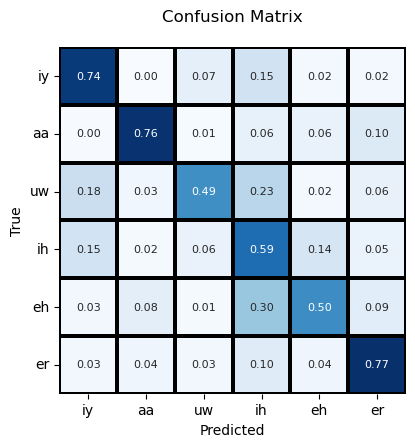

In [11]:
#######################
# modify one of the next four lines to do the requested experiments
feature_selection = slice(0,26)       # default: slice(0,26)       
n_components = 8                   # default: 8
max_iter = 2                       # default: 2
priors =  'training'                  # default: 'training'  (alternative: 'uniform')
######################
# you can also modify other training settings by using this **kwargs{}
#  kwargs = dict(verbose=2,verbose_interval=1)   will print loglik-change (per sample) per iteration
#  kwargs = dict(init_params='random')           will change initialization to random instead of KMeans  (more convergence effort is needed)
#  kwargs = dict(reg_cover=1.e-6,tol=1.e-3)      are some other parameters controlling regularization and a stopping criterion for training
#
kwargs =dict(verbose=2,verbose_interval=1,init_params='kmeans')          
################
X_train = X_train_vow6[:,feature_selection]
y_train = y_train_vow6
X_test = X_test_vow6[:,feature_selection]
y_test = y_test_vow6
classes_used = vow6
# train the model
clf_GMM,_ = train_GMM(X_train, y_train,  classes=classes_used,
                    n_components=n_components, max_iter=max_iter,Verbose=True,**kwargs)
# test the model
acc_test,cm = test_GMM(clf_GMM, X_test, y_test,  Verbose=True, norm=True, priors=priors)

### Exercise 2: Training with all phonemes

##### Things to explore:

- run the training with default parameters
- have a look at the confusion matrix
    + in what range are the per phone accuracies situated ?
    + find the most confusable phone pairs
        - some of the confusable pairs were a bit to be expected; explain 
        - do such confusable pairs hint to problems with phonetic transcriptions or to issues with the pronunciations ? 
        - will such confusable pairs be a big problem in an integrated speech recognition system with lexicon and language model 

Training Set:  Accuracy = 55.70%
Training Set:  LL(per sample) = -30.52
Test Set:      Accuracy = 49.37%


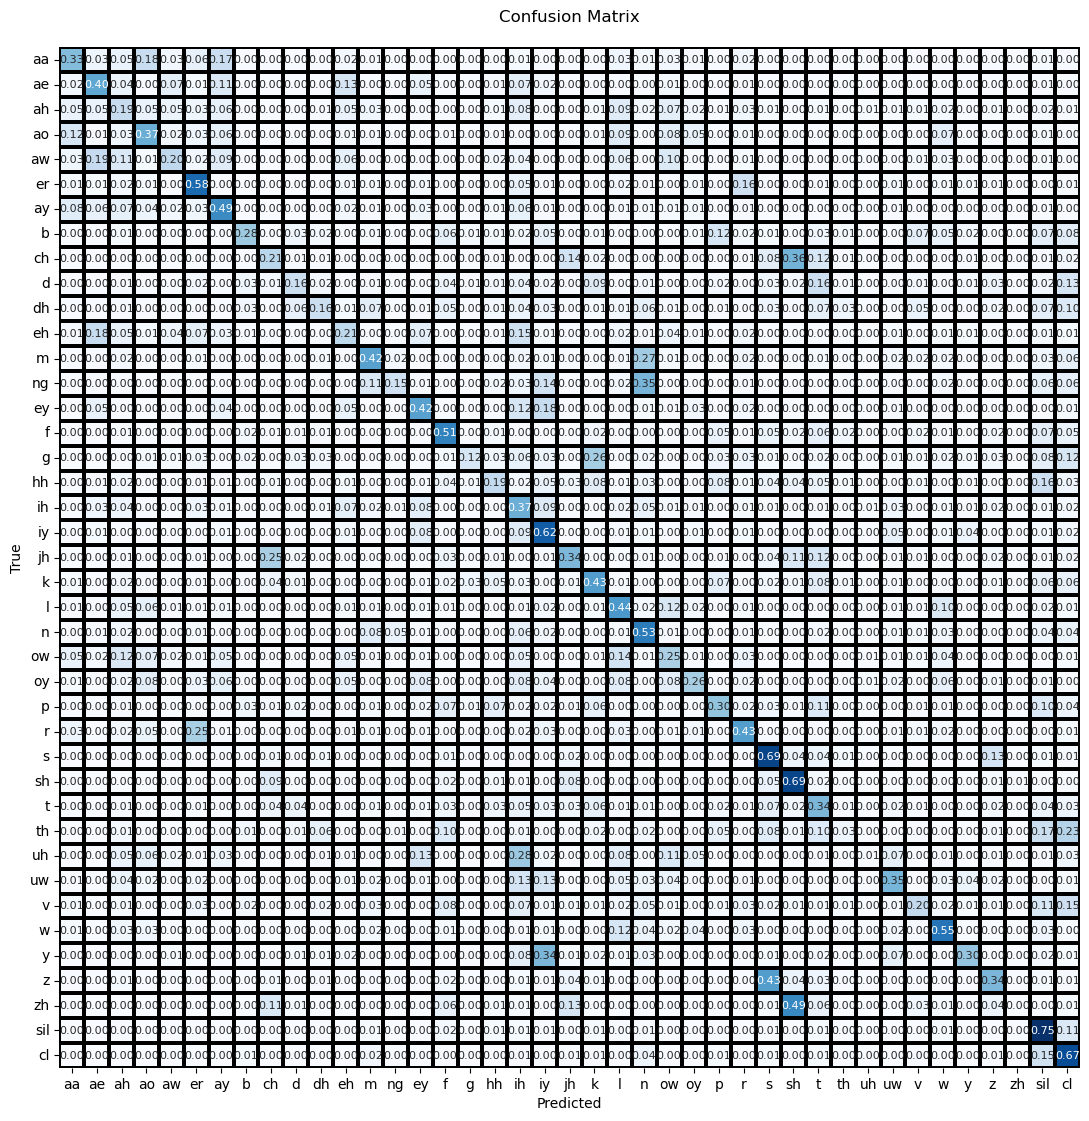

In [13]:
#################
# only modify one of the next four lines to do the requested experiments
feature_selection = slice(0,26)       # default: slice(0,26)       
n_components = 8                      # default: 8
max_iter = 2                          # default: 2
priors =  'training'                  # default: 'training'  (alternative: 'uniform')
################
X_train = X_train_db[:,feature_selection]
y_train = y_train_db
X_test = X_test_db[:,feature_selection]
y_test = y_test_db
classes_used = classes
# train the model
clf_GMM,_ = train_GMM(X_train, y_train,  classes=classes_used,
                    n_components=n_components, max_iter=max_iter, Verbose=True)
# test the model
acc_test,cm = test_GMM(clf_GMM, X_test, y_test,  Verbose=True, norm=True, priors=priors)

In [25]:
## save the trained model(s) to disk
## save_pickle(clf_GMM,"GMM_TIMIT_D26_G64.pk")
##
# some results that you might expect to get  (small discrepancies between training and testing)
# TIMIT_MINI_D26  49%
# TIMIT_D26_G8    53%
# TIMIT_D26_G64   56%

## Exercise 3: Using the model in Continuous Speech Recognition

In this part we will use the trained models to compute frame probabilities (likelihoods or posteriors) for an utterance.
Computing these frame probabilities is just a first step towards continuous speech recognition.  
We can evaluate frame recognition rate within a sentence.   
Also we can observe how stable / unstable such observation probabilities are over time.

##### Note on transcriptions and labels
NOTE 1.
One of the labels is 'cl', i.e. closure before a plosive.  These are often present in your transcriptions, e.g.
-  bricks: b r ih cl k s

NOTE 2.
The transcriptions in TIMIT are labels as given by humans listening to very short fragments of an utterance.   Their transcription reflect the sound that they here .  Thus it is NOT a  CANONICAL transcription which is the transcription you find in a dictionary.
As such you may encounter pronunciation variants:
- is: ih s
- is: iy z

##### Questions.
Question 1:
- Select example 2 ("bricks")
- Have a look at the frame probabilites
    + where does the recognizer seems fairly certain
    + assuming  you only have these prob's as your input (i.e. this is what a recognizer gets), what word would you form if you only take into accounts segments of a couple frames that are consistently recognized as the same phone?
    
Question 2:
- Give an example of phonetic confusion that in your opinion will probably not hurt the recognizer when it can use lexical information

In [14]:
# Import a model or reuse one of the models that you have trained above
#######################################################################
# clf_test = get_pickle("GMM_TIMIT_MINI_D26_G8.pk")   # D26 = 26 dim features, G8 = 8 Gaussians, TIMIT_MINI = training database
clf_test = clf_GMM

In [15]:
# select a test file for analysis
#################################
example = 1
test_files = ['test/dr1/faks0/si2203',  'test/dr8/fcmh1/si1493', 'test/dr4/fadg0/si1279', 'train/dr1/fcjf0/sx307', 'train/dr1/fdaw0/sx236'] #,'train/dr1/fdml0/si1779']
name = test_files[example]
if name == 'test/dr1/faks0/si2203':    # segment selection "for this dive"
    transcrition = "the reasons for this dive are foolish by now"
    segment_transcription = "for this dive"
    phn_sel = np.array(['sil','cl','d','dh','z','s','f','v','r','er','aa','ay','ah','ao','ih']) #'sil','iy','aa','cl'
    frames=[132,209] # [150,250] # #  [160,185]   # [250,350] # 
elif name ==  'test/dr8/fcmh1/si1493':  # segment selection "by that time perhaps something "
    phn_sel = np.array(['sil','cl','b','dh','t','p','s','m','ay','aa','ae','ah','iy','th'])
    phn_sel = np.array(['sil','cl','b','dh','t','p','ay','aa','ae','ah','eh'])
    frames=[10,65]
elif name == 'test/dr4/fadg0/si1279':  # bricks are an alternative
    transcription = "bricks are an alternative"
    segment_transcription = "bricks"
    phn_sel = np.array(['sil','cl','b','dh','t','k','r','l','s','ih','iy','ae','eh'])
    frames = [10,50]
elif name == 'train/dr1/fcjf0/sx307': # the meeting is now adjourned
    transcription = "the meeting is now adjourned"
    segment_transcription = "the meeting is now"
    phn_sel = np.array(['sil','ih','iy','ey','aw','ay','dh','t','s','f','z','ng','n','m']) 
    frames = [5,80]
elif name == 'train/dr1/fdaw0/sx236': # clear pronunciation is appreciated
    transcription = "clear pronunciation is appreciated"
    segment_transcription = "is appreciated"
    phn_sel = np.array(['sil','cl','ah','aw','ae','eh','ey','ih','iy','uh','b','d','dh','p','t','k','r','l','s','sh','ng','n','m'])
    frames = [160,250]
else:
    phn_sel = phnset
    frames = [0,-1]
#
shift = 0.01
indx_sel = [classes.index(phn) for phn in phn_sel]
frame_sel = slice(frames[0],frames[1])
x0 = (frames[0]+.5)*shift

# audio and feature extraction
example_audio, sample_rate = pyspch.audio.load(timit_root + 'audio/' + name + ".wav")
example_spg = pyspch.sp.feature_extraction(example_audio, sample_rate=sample_rate) #, **setup.feature_args)
example_features = pyspch.sp.feature_extraction(example_audio, **feature_args)
# transcription + word segmentation 
# transcription + word segmentation 
example_txt = pyspch.read_txt(timit_root + 'segmentation/' + name + ".txt")
example_wrd = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".wrd", dt=1/sample_rate)
print(example_txt)    
# get reference segmentation and labels , phone segmentation (+ as index)
example_phn = pyspch.timit.read_seg_file(timit_root + 'segmentation/' + name + ".phn", fmt="float32", dt=1/sample_rate,xlat='timit61_timit41')
example_lab = pyspch.seg2lbls(example_phn, n_frames=example_features.shape[1],pad_lbl='sil') 

['0 40448 By that time, perhaps something better can be done.']


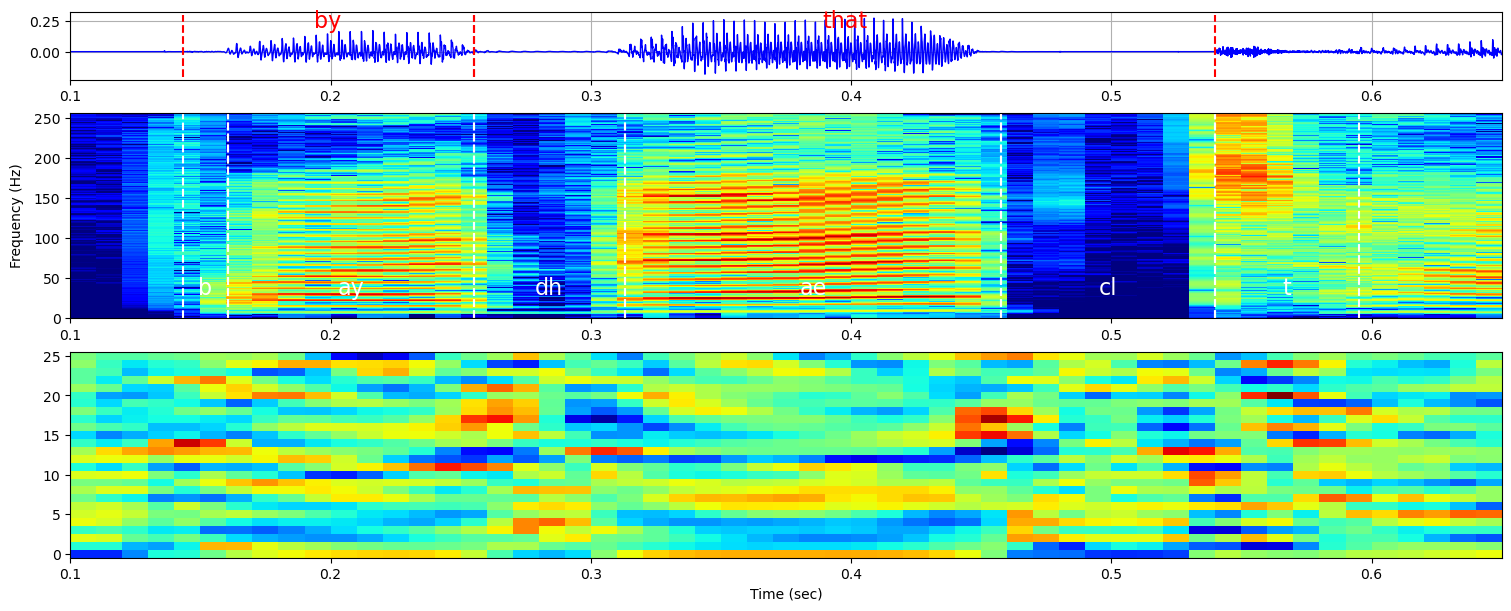

In [16]:
#  SHOW THE EXAMPLE: waveform, spectrogram, features, reference transcription and segmentation
#################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,
                            frames=frames, sample_rate=sample_rate, figsize=(15,6), img_ftrs=[example_features])
fig.add_seg_plot(example_phn, iax=1, ypos=.15, color='w') 
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, color='r') # seg
display(fig)
display(Audio(data=example_audio,rate=sample_rate))

In [17]:
# compute frame posterior probabilities and do frame by frame recognition, compute the frame error rate in the sentence
##########################################################################
postprob_gmm = clf_test.predict_proba(X=example_features.T)
# evaluate frame based recognition wrt. manual segmentations
y_gmm_idx = np.argmax(postprob_gmm, axis=1)
y_gmm_lab = [classes[i] for i in y_gmm_idx]
# alternative
# y_gmm_lab = clf_GMM.predict(X=example_features.T)
y_gmm_seg = pyspch.lbls2seg(y_gmm_lab)
n_corr = np.sum([y_gmm_lab[i] == example_lab[i] for i in range(len(example_lab))])
print("Frame Recognition Rate (for full utterance): %.2f %%" % (100.*n_corr/len(example_lab)))

Frame Recognition Rate (for full utterance): 34.52 %


In [18]:
# plot frame posterior probs and phones for a short segment and a selection of phones
######################################################################################
fig = pyspch.display.PlotSpgFtrs(wavdata=example_audio, spgdata=example_spg,dy=1,row_heights=[1.5,2,4,4,.75],
                                 frames=frames, sample_rate=sample_rate, figsize=(15,10), img_ftrs=[None,None])
fig.add_seg_plot(example_phn, iax=1, ypos=.85, color='k') # seg
fig.add_seg_plot(example_wrd, iax=0, ypos=.9, Lines=True, color='r')

#plot_probs(prob_dnn_sel, phn_sel,fig=fig, iax=0, x0=frames[0]*.01, style="line", title="DNN Posterior Probs") # probs
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=2, x0=frames[0]*.01, style="line", title="GMM Posterior Probs")
plot_probs(postprob_gmm[frame_sel,indx_sel], phn_sel,fig=fig, iax=3, x0=frames[0]*.01, style="img", title="GMM Posterior Probs")

fig.add_seg_plot(y_gmm_seg, iax=4, ypos=.25, Lines=True, color='b') # predicted labels
fig

NameError: name 'plot_probs' is not defined